# Traffic sign recognition

### Goal of this notebook

The purpose of this notebook is to systematically explore the results of changing parameters in an image recognition network. Better data on the effect of changes leads to better understanding of the effect of these parameters which hopefully will lead to greater efficiency when building networks in the future.

### Contents

* [Data](#data)
* [Model](#model)
* [Generate Data](#generate_data)
* [Evaluation](#evaluation)

<a name='data'></a>
# Data


## TSRD traffic sign dataset

The dataset used comes from the [Pattern Analysis & Learning Group](http://www.nlpr.ia.ac.cn/pal/) at the National Laboratory of Pattern Recognition of the Institute of Automation of the Chinese Academy of Sciences.

The [data](http://www.nlpr.ia.ac.cn/pal/trafficdata/index.html) is introduced as:
> The Chinese traffic sign databases include traffic sign recognition database,traffic sign detection database and traffic panel database. All databases are collected by camera under nature scenes or from BAIDU Street View.

The mentioned three datasets are:
* [Recognition](http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html): centered images of traffic sign in 56 categories, categorized only by number
* [Detection](http://www.nlpr.ia.ac.cn/pal/trafficdata/detection.html): images in which a traffic sign is somewhere on the picture
* [Traffic panels](http://www.nlpr.ia.ac.cn/pal/trafficdata/panel.html): like detection, but road signs indicating directions

The interest in the current notebook is in image recognition, that is, the first of the three datasets.

## Getting the data

In [1]:
DATADIR = '../tmp2'

import os
if not os.path.exists(DATADIR):
    raise OSError('Data directory not found. Please, create {} before continuing'.format(DATADIR))

### Download dataset

Data has already been split into a set for training and another for testing.

* [TSRD Train](http://www.nlpr.ia.ac.cn/pal/trafficdata/tsrd-train.zip)
* [TSRD Train Annotation](http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Train%20Annotation.zip)
* [TSRD Test](http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Test.zip)
* [TSRD Test Annotation](http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Test%20Annotation.zip)

When downloading we will not check for newer versions being available (-N) as the server doesn't give that information. We only check if the file already exists, if so, we won't download.

In [2]:
print('Downloading data files to {}'.format(DATADIR))
!wget -P $DATADIR -nc http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Train%20Annotation.zip
!wget -P $DATADIR -nc http://www.nlpr.ia.ac.cn/pal/trafficdata/tsrd-train.zip
!wget -P $DATADIR -nc http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Test%20Annotation.zip
!wget -P $DATADIR -nc http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Test.zip

File ‘../tmp2/TSRD-Train Annotation.zip’ already there; not retrieving.

File ‘../tmp2/tsrd-train.zip’ already there; not retrieving.

File ‘../tmp2/TSRD-Test Annotation.zip’ already there; not retrieving.

File ‘../tmp2/TSRD-Test.zip’ already there; not retrieving.



### Unzip the dataset

We unzip the data under `DATADIR/tsrd` if that directory does not exist yet. Training data goes under the subdirectory `train` and test data under the subdirectory `test`.

In [3]:
TSRDDIR = 'tsrd'
if not os.path.exists('{}/{}'.format(DATADIR, TSRDDIR)):
    print('Creating {}/{} and unzipping data'.format(DATADIR, TSRDDIR))
    os.mkdir('{}/{}'.format(DATADIR, TSRDDIR))
    
    # Unzip training data
    os.mkdir('{}/{}/train'.format(DATADIR, TSRDDIR))
    !unzip -q -d $DATADIR/$TSRDDIR "$DATADIR/TSRD-Train Annotation.zip"
    !unzip -q -d $DATADIR/$TSRDDIR/train "$DATADIR/tsrd-train.zip"
    print('Unzipped training data in {}/{}/train'.format(DATADIR, TSRDDIR))
    
    # Unzip test data
    os.mkdir('{}/{}/test'.format(DATADIR, TSRDDIR))
    !unzip -q -d $DATADIR/$TSRDDIR "$DATADIR/TSRD-Test Annotation.zip"
    !unzip -q -d $DATADIR/$TSRDDIR/test "$DATADIR/tsrd-Test.zip"
    print('Unzipped test data in {}/{}/test'.format(DATADIR, TSRDDIR))
        
else:
    print('Data is already unzipped under {}/{}'.format(DATADIR, TSRDDIR))
                      

Data is already unzipped under ../tmp2/tsrd


## Exploring the data

### Metadata

For each of train and test data a CSV file is provided with meta-data on the traffic sign pictures. Here is an example line:

> 000_0026.png;105;99;17;7;92;87;0;

The dataset is not explained, but exploration led me to the following description:

1. Filename.  Note the format of the filename: three digits for category, then an underscore, then four digits for the index of the image. More details on the filename when preprocessing the data.
2. Width: width of image
3. Height: height of image
4. Coordinate: top left x
5. Coordinates: top left y
6. Coordinates: bottom right x
7. Coordinates: bottom right y
8. Category: traffic sign category.

Note that the category is represented both as part of the filename as a string of three digits and in the final column of the CSV file as an integer.

Let us import the training data and explore it.

In [4]:
import pandas as pd
# ';' separated CSV ends with trailing ';' which leads to a empty column at the end. Usecols tells to ignore it.
train_df = pd.read_csv('{}/{}/TsignRecgTrain4170Annotation.txt'.format(DATADIR, TSRDDIR), 
                       sep=';', header=None, 
                       names=['filename','width','height',
                              'topx','topy','bottomx','bottomy','category'],
                       dtype={'filename': str, 
                              'width': int, 'height': int, 'bottomx': int, 'bottomy': int,
                              'category': str},
                       usecols=[0,1,2,3,4,5,6,7])

test_df = pd.read_csv('{}/{}/TsignRecgTest1994Annotation.txt'.format(DATADIR, TSRDDIR), 
                       sep=';', header=None, 
                       names=['filename','width','height',
                              'topx','topy','bottomx','bottomy','category'],
                       dtype={'filename': str, 
                              'width': int, 'height': int, 'bottomx': int, 'bottomy': int,
                              'category': str},
                       usecols=[0,1,2,3,4,5,6,7])
train_df.head()

,filename,width,height,topx,topy,bottomx,bottomy,category
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


### View

Let's view some images.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageDraw
%matplotlib inline

In [6]:
def display_random(df, settype='train'):
    '''Display random set of images'''
    indices = []
    for i in range(25):
        indices.append(random.randrange(df.shape[0]))
        
    plt.figure(figsize=(10,10))
    for i in range(25):
        index = indices[i]
        filename, width, height, topx, topy, bottomx, bottomy, cat = df.iloc[index]

        p = '{}/tsrd/{}/{}'.format(DATADIR, settype, filename)
        img = Image.open(p)
        ax = plt.subplot(5, 5, i+1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('{}/{} ({},{})'.format(index, cat, width,height))

    plt.show()

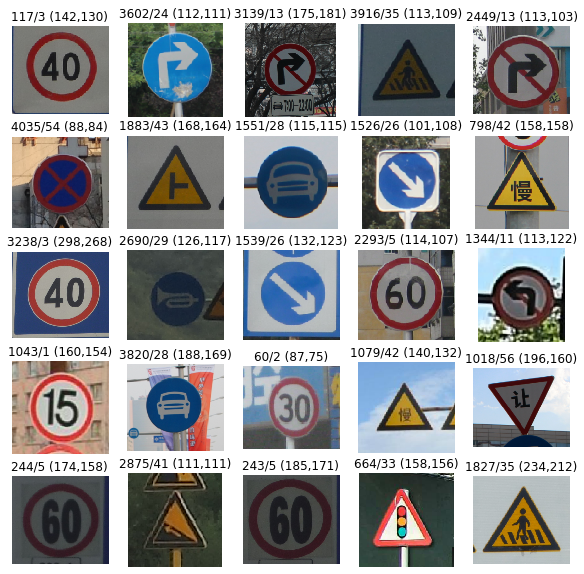

In [7]:
display_random(train_df, settype='train')

### Categories

The categories for traffic signs are only expressed in numbers. There is no explanation for what they mean.

When we look at the categories in the train and test set, we find that there are more categories in the train dataset, than in the test set.

In [8]:
CATEGORIES = train_df['category'].unique().tolist()
print('Found {} categories in the training set'.format(len(CATEGORIES)))
print('Found {} categories in the test set'.format(len(test_df['category'].unique().tolist())))

Found 58 categories in the training set
Found 54 categories in the test set


For now, we store a list of categories of the train dataset in the variable `CATEGORIES`. It will turn up again later in this notebook.

### Cropping

Besides width and height of the images, we have a top-left coordinate (topx, topy) and bottom-right coordinate (bottomx, bottomy) that defines a crop of the image.

In [9]:
def display_cropping(df, settype='train'):
    '''Display random image from dataframe and its cropped version'''
    index = random.randrange(df.shape[0])
    filename, width, height, topx, topy, bottomx, bottomy, _ = df.iloc[index]

    p = '{}/tsrd/{}/{}'.format(DATADIR, settype, filename)
    img = Image.open(p)
    img_cropped = img.crop((topx, topy, bottomx, bottomy))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('({},{})'.format(width,height))

    ax2.imshow(img_cropped)
    ax2.axis('off')
    ax2.set_title('({},{})'.format((bottomx-topx), (bottomy-topy)))

    plt.show()

Let's see what it looks like, putting a full image and a cropped version side by side. To see a different image, just execute the cell again.

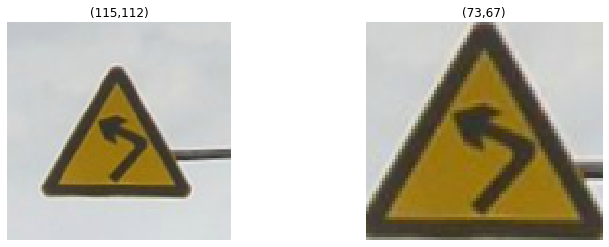

In [10]:
display_cropping(train_df, settype='train')

## Sizes of images in the dataset

### Extend dataframe with cropping sizes

We add the width and height of the croppings to our dataframe.

In [11]:
train_df['crop_width'] = train_df['bottomx'] - train_df['topx']
train_df['crop_height'] = train_df['bottomy'] - train_df['topy']

## Explore sizes

In [12]:
train_df[['width','height','crop_width', 'crop_height']].describe()

,width,height,crop_width,crop_height
count,4170.000000,4170.000000,4170.000000,4170.000000
mean,152.137170,140.856595,102.859472,100.853717
std,59.335121,52.668581,43.366035,40.970807
min,26.000000,28.000000,23.000000,23.000000
25%,109.000000,102.000000,72.000000,71.000000
50%,143.000000,132.000000,94.000000,94.000000
75%,182.000000,170.000000,125.000000,123.000000
max,491.000000,402.000000,393.000000,353.000000


We see that there is a wide variety in sizes.

### Visualize size distribution

In [13]:
def visualize_distribution(df, settype='train'):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,9))

    ax1.hist(df['width'],bins=20)
    ax1.set_title('histogram image width')

    ax2.hist(df['height'], bins=20)
    ax2.set_title('histogram image height')

    ax3.hist(df['crop_width'], bins=20)
    ax3.set_title('histogram cropped width')

    ax4.hist(df['crop_height'], bins=20)
    ax4.set_title('histogram cropped height')

    plt.show()

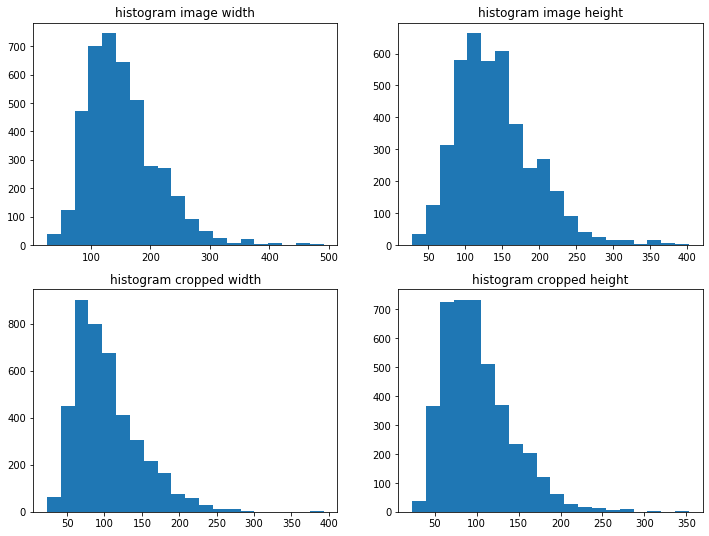

In [14]:
visualize_distribution(train_df, settype='train')

### Conclusions on size distribution

We see that there is a relatively small number of small images in the dataset and a long tail of relatively larger images. Presumably, the former are harder to recognize than larger and hence more detailed images.
The larger images should give no issues. Additionally, the smaller images need not be a problem, unless the small images happen to be overly represented in specific traffic sign categories. In that case, these categories can perform significantly weaker than others.

In [15]:
#IMG_WIDTH = 60
#IMG_HEIGHT = 60

<a name='model'></a>
# Model

We use a standard image processing model with several Convolution/MaxPooling layers, flattening, dropout, and two fully connected layers.

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Are you running TensorFlow 2.x?
tf.__version__

We wrap the creation of the model in a method, so we can parametrize the models and compare different models.

In [17]:
def create_model(img_width, img_height):
    IMAGE_SHAPE = (img_width, img_height)
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image IMG_WIDTH x IMG_HEIGHT with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SHAPE+(3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'), #, kernel_regularizer=tf.keras.regularizers.l2(l=0.03)),
        tf.keras.layers.Dense(len(CATEGORIES), activation='softmax')
    ])
    # Store the initial weights of the model in a variable
    return model

## Reset model
As we want to loop through different parameters, we need to reset the weights of our model. The easiest way to do this is to store the weights in a variable. To reset the model, we then set the model's weights to the ones in this variable.

In [18]:
def reset_model(model):
    model.set_weights(weights)

In [19]:
def compile(model):
    #optimizer=tf.keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True)
    optimizer='adam'
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

<a name='generate_data'></a>
# Generate data

We use `ImageDataGenerator` to generate batches of tensor image data with real-time data augmentation to serve as input to our model.

### Fix for incompatible broadcasting of logits and labels

When just using the train and test dataset without ado, we will get into trouble when fitting the model:

> InvalidArgumentError: logits and labels must be broadcastable: logits_size=[32,58] labels_size=[32,54]

While the training set has 58 categories, the test set has only 54 categories. If we train without testing, the model.fit function will balk as the categories are one hot encoded, which leads to the train and test data being converted to arrays of a different dimension.

Earlier we defined all categories of the train dataset, which encompasses the categories of the test dataset, as a list named `CATEGORIES`.
Now, we pass that list on to the generator as the value for the parameter `classes`.

In [20]:
BATCH_SIZE = 32

def create_generators(augmentation_args, img_width, img_height):
    # Add rescaling to the image augmentation
    augmentation_args['rescale'] = 1.0/255.0
    train_datagen = ImageDataGenerator(**augmentation_args)
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory='{}/tsrd/train/'.format(DATADIR),
        x_col='filename',   
        y_col='category',
        classes=CATEGORIES,
        class_mode='categorical',
        target_size=(img_width, img_height),
        batch_size=BATCH_SIZE
    )

    test_datagen = ImageDataGenerator(rescale=1./255.0)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        directory='{}/tsrd/test/'.format(DATADIR),
        x_col='filename',
        y_col='category',
        classes=CATEGORIES,
        class_mode='categorical',
        target_size=(img_width, img_height),
        batch_size=BATCH_SIZE
    )
    return train_generator, test_generator

<a name='evaluation'></a>
# Evaluation

In [21]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ProgbarLogger
import time

class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100, epochs=5):
        self.display = display
        self.epochs = epochs

    def on_train_begin(self, logs={}):      
        self.epoch_counter = 0
        if self.epochs >= 16:
            print('Logging every {} epochs...'.format(self.display))

    def on_epoch_begin(self, batch, logs={}): 
        self.epoch_timestamp = time.perf_counter()

    def on_epoch_end(self, batch, logs={}):    
        self.epoch_counter += 1     
        if self.epochs < 16 or self.epoch_counter % self.display == 0:
            now = time.perf_counter()
            print ("Epoch: {} - loss: {:.4f} - val_loss: {:.4f} - train acc: {:.4f} - val acc: {:.4f} ({:.2f} sec)".format( 
                   self.epoch_counter, logs['loss'], logs['val_loss'], 
                    logs['accuracy'], logs['val_accuracy'], now-self.epoch_timestamp))

### Early stopping

As our primary interest is in investigating how different parameters influence training results, we can stop training early when insufficient progress is made.

For this we use the standard [EarlyStopping Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, mode='min', verbose=1)

In [23]:
from copy import deepcopy

def run(args, img_width, img_height, silent=True):
    if not silent:
        print("Parameters: images: ({},{}), {}".format(img_width, img_height, str(args)))
    model = create_model(img_width, img_height)
    weights = model.get_weights()

    compile(model)
    
    train_generator, test_generator = create_generators(args, img_width, img_height)

    start = time.perf_counter()
    
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=test_generator,
        verbose=0,
        callbacks=[
            PeriodicLogger(PRINT_LOG_PER_EACH, epochs=EPOCHS),
            ProgbarLogger(count_mode='samples'),
            early_stopping
        ]
    )
    end = time.perf_counter()
    print('Execution of {} epochs in {:.1f} minutes => {:.2f} sec / epoch'.format(len(history.epoch), (end-start)/60, (end-start)/len(history.epoch)))
    return deepcopy(history.history)

### Fit the model with the data

We loop over a number of parameters:
* Image size
* shear_range
* zoom_range

Note that if one of the parameters is changing the other is kept at the initial value. That is, no attempt is made to loop over all _combinations_ of parameters.

In [24]:
EPOCHS = 5
PRINT_LOG_PER_EACH = 1

augmentation_args = dict(
    shear_range=0.0,
    fill_mode='nearest',
    zoom_range=0.0,
    rotation_range=0.0,
    vertical_flip=False,
    height_shift_range=0.0,
    width_shift_range=0.0
    #brightness_range=(-0.8,0.8)
)

image_sizes = [(60,60), (80,80), (100,100)]

#vertical_flip = [True, False]
#horizontal_flip = [True, False]
shear_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
zoom_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]

mod_args = {'shear_range': shear_range, 'zoom_range': zoom_range}

def run_series(args, image_sizes, mod_args, silent=True):
    res = []
    start = time.perf_counter()

    for img_width, img_height in image_sizes:
        for k, lst in mod_args.items():
            for v in lst:
                a = deepcopy(args)
                a[k] = v
                val_acc = run(a, img_width, img_height, silent=silent)
                res.append(((img_width, img_height), k, v, val_acc))
    end = time.perf_counter()
    print('Run completed in {:.1f} minutes'.format((end-start)/60))
    return res

res = run_series(augmentation_args, image_sizes, mod_args, silent=True)

Found 4170 validated image filenames belonging to 58 classes.
Found 1994 validated image filenames belonging to 58 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch: 1 - loss: 3.1025 - val_loss: 2.8862 - train acc: 0.2094 - val acc: 0.2207 (40.79 sec)
Epoch: 2 - loss: 2.0610 - val_loss: 2.1607 - train acc: 0.4153 - val acc: 0.3601 (38.61 sec)
Epoch: 3 - loss: 1.4342 - val_loss: 1.8378 - train acc: 0.5729 - val acc: 0.4213 (38.18 sec)
Epoch: 4 - loss: 1.0425 - val_loss: 1.5281 - train acc: 0.6787 - val acc: 0.5486 (40.10 sec)
Epoch: 5 - loss: 0.8116 - val_loss: 1.6011 - train acc: 0.7472 - val acc: 0.5366 (37.96 sec)
Execution of 5 epochs in 3.3 minutes => 39.19 sec / epoch
Found 4170 validated image filenames belonging to 58 classes.
Found 1994 validated image filenames belonging to 58 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch: 1 - loss: 3.2806 - val_loss: 2.9183 - train acc: 0.1554 - val acc: 0.1846 (40.35 sec)
Epoch: 2 - loss: 2.2999 - val_loss: 

### Results

Let's put the results in a table.

In [25]:
def results_to_table(lst):
    d = {'size': [], 'parameter': [], 'value': [], 'training loss': [], 'test accuracy': []}
    for (imgw,imgh), k, v, h in lst:
        d['size'].append('{}x{}'.format(imgw, imgh))
        d['parameter'].append(k)
        d['value'].append(v)
        d['training loss'].append(h['loss'][-1])
        d['test accuracy'].append(h['val_accuracy'][-1])
    df = pd.DataFrame(d)
    return df

In [26]:
result_df = results_to_table(res)
result_df

,size,parameter,value,training loss,test accuracy
0,60x60,shear_range,0.00,0.811615,0.536610
1,60x60,shear_range,0.05,0.972212,0.542628
2,60x60,shear_range,0.10,0.810718,0.593781
3,60x60,shear_range,0.15,0.946608,0.527583
4,60x60,shear_range,0.20,0.901272,0.555667
5,60x60,shear_range,0.25,0.780469,0.594784
6,60x60,zoom_range,0.00,0.713679,0.625878
7,60x60,zoom_range,0.05,0.871247,0.540622
8,60x60,zoom_range,0.10,0.808592,0.574724
9,60x60,zoom_range,0.15,0.895111,0.522568


### Plot the results

In [27]:
def plot(history, title=''):
    '''Plot validation loss and accuracy next to each other'''
    
    print("\nConfiguration: {}. Validation accuracy: {}".format(title, history['val_accuracy'][-1]))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
    # Plot training & validation accuracy values
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_title('Model accuracy: {}'.format(title))
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_title('Model loss: {}'.format(title))
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='upper left')
    
    plt.show()

In [28]:
#print(res)


Configuration: shear_range = 0.0 (60x60). Validation accuracy: 0.5366098284721375


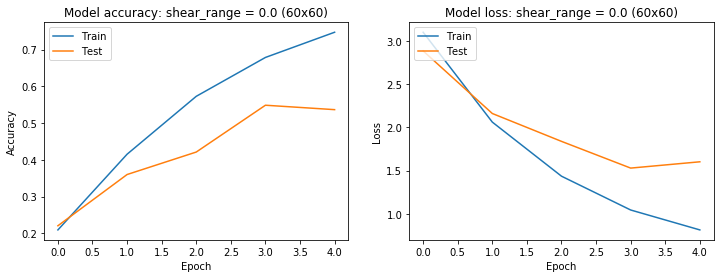


Configuration: shear_range = 0.05 (60x60). Validation accuracy: 0.5426278710365295


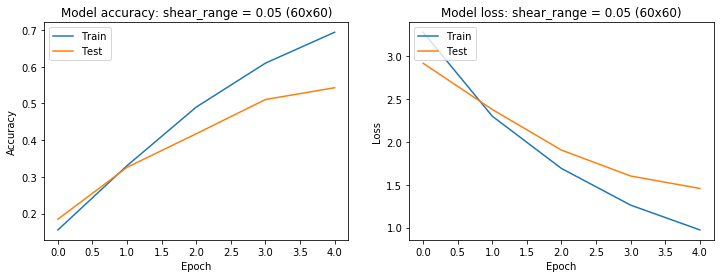


Configuration: shear_range = 0.1 (60x60). Validation accuracy: 0.5937813520431519


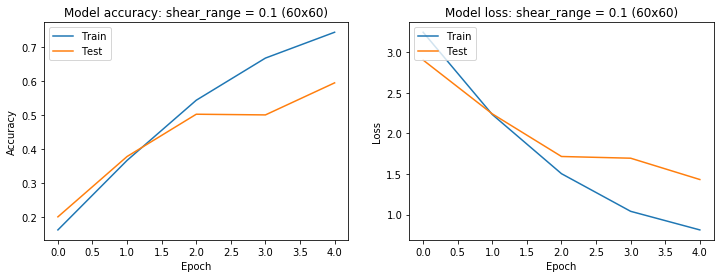


Configuration: shear_range = 0.15 (60x60). Validation accuracy: 0.5275827646255493


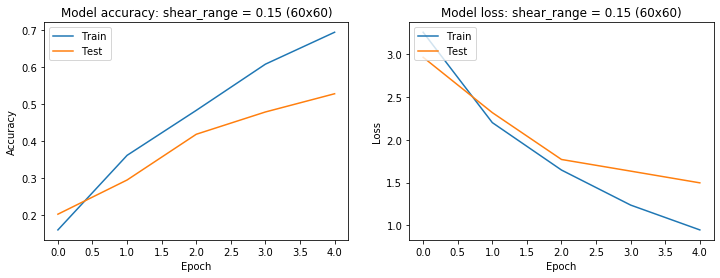


Configuration: shear_range = 0.2 (60x60). Validation accuracy: 0.555666983127594


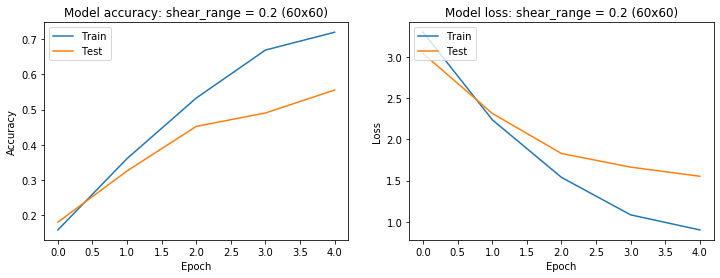


Configuration: shear_range = 0.25 (60x60). Validation accuracy: 0.5947843790054321


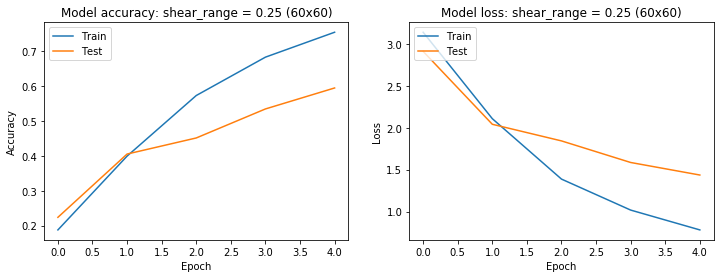


Configuration: zoom_range = 0.0 (60x60). Validation accuracy: 0.6258776187896729


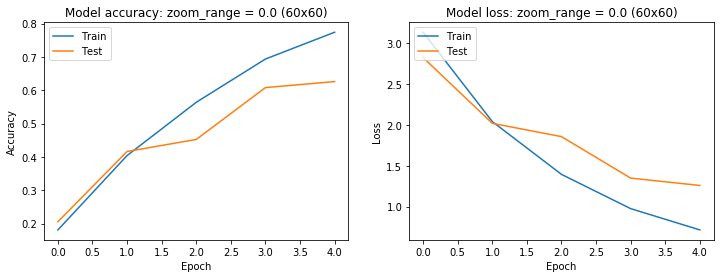


Configuration: zoom_range = 0.05 (60x60). Validation accuracy: 0.5406218767166138


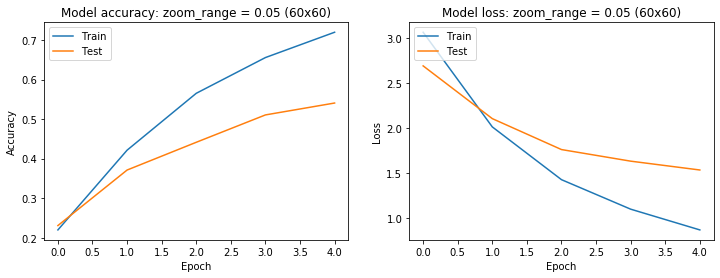


Configuration: zoom_range = 0.1 (60x60). Validation accuracy: 0.5747241973876953


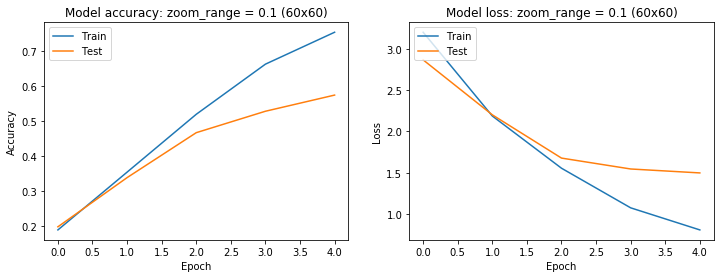


Configuration: zoom_range = 0.15 (60x60). Validation accuracy: 0.5225676894187927


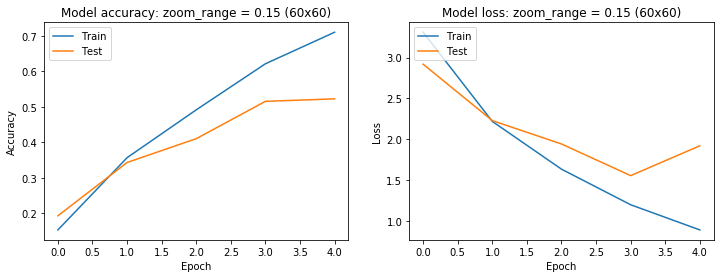


Configuration: zoom_range = 0.2 (60x60). Validation accuracy: 0.5305917859077454


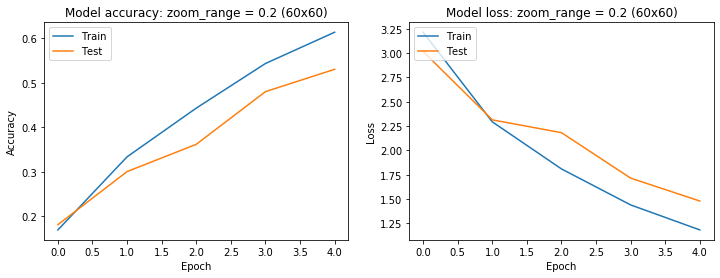


Configuration: zoom_range = 0.25 (60x60). Validation accuracy: 0.5356068015098572


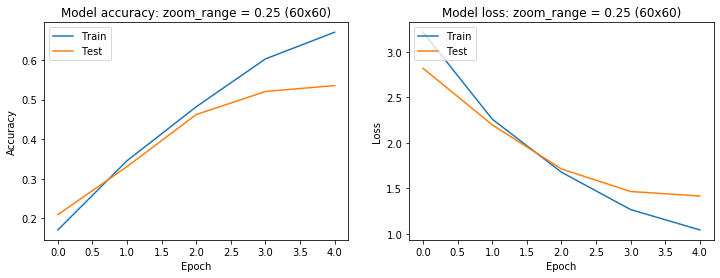


Configuration: shear_range = 0.0 (80x80). Validation accuracy: 0.6198595762252808


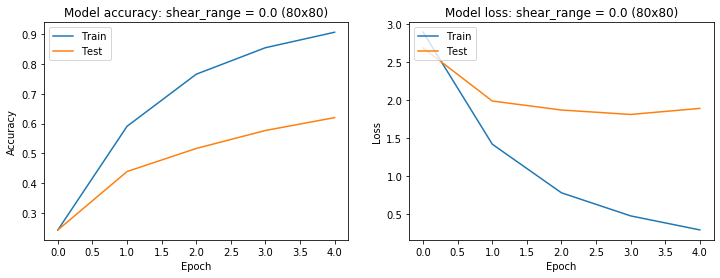


Configuration: shear_range = 0.05 (80x80). Validation accuracy: 0.6389167308807373


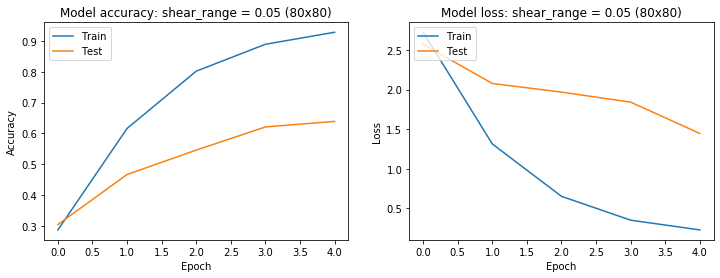


Configuration: shear_range = 0.1 (80x80). Validation accuracy: 0.6459378004074097


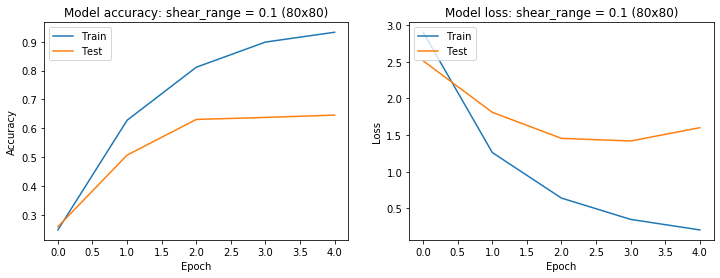


Configuration: shear_range = 0.15 (80x80). Validation accuracy: 0.6579739451408386


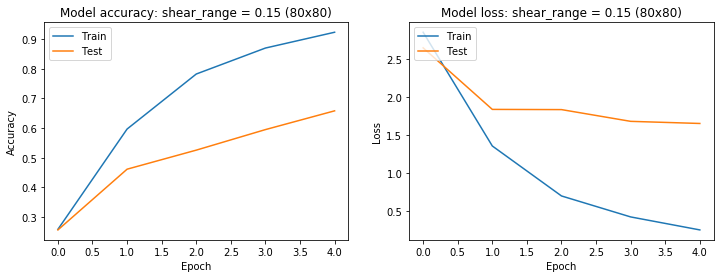


Configuration: shear_range = 0.2 (80x80). Validation accuracy: 0.6659979820251465


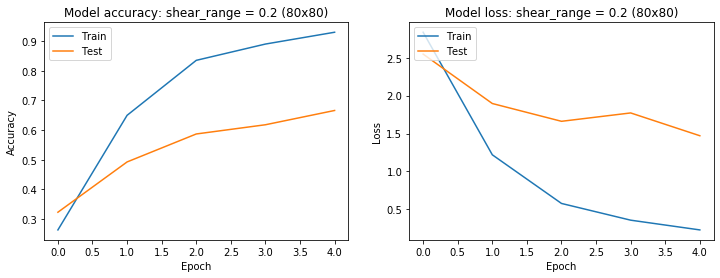


Configuration: shear_range = 0.25 (80x80). Validation accuracy: 0.6599799394607544


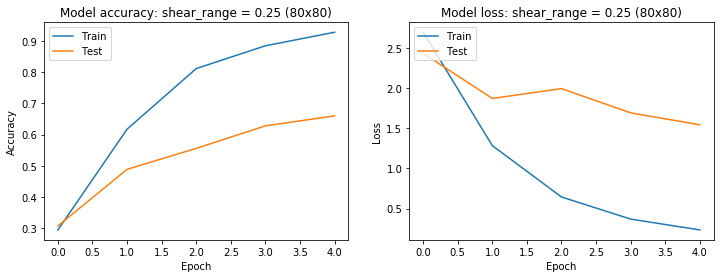


Configuration: zoom_range = 0.0 (80x80). Validation accuracy: 0.620862603187561


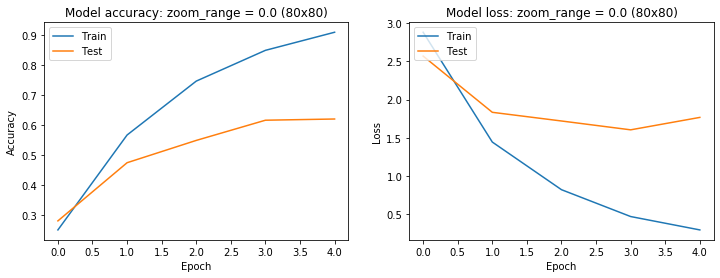


Configuration: zoom_range = 0.05 (80x80). Validation accuracy: 0.6359077095985413


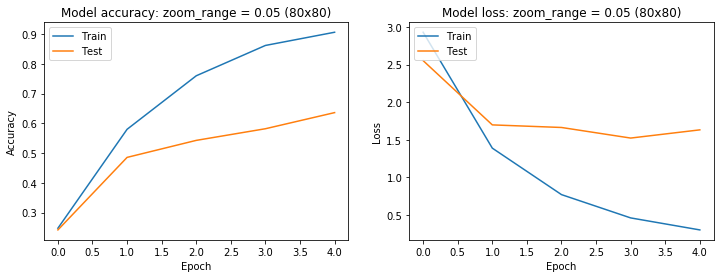


Configuration: zoom_range = 0.1 (80x80). Validation accuracy: 0.6870611906051636


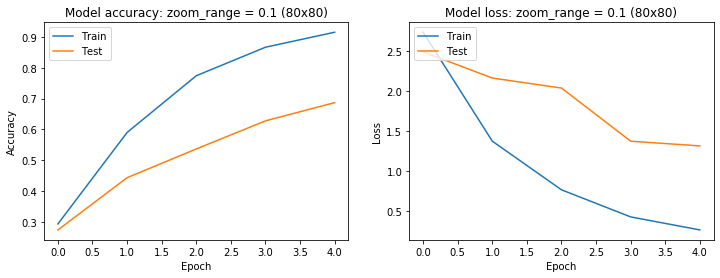


Configuration: zoom_range = 0.15 (80x80). Validation accuracy: 0.6790370941162109


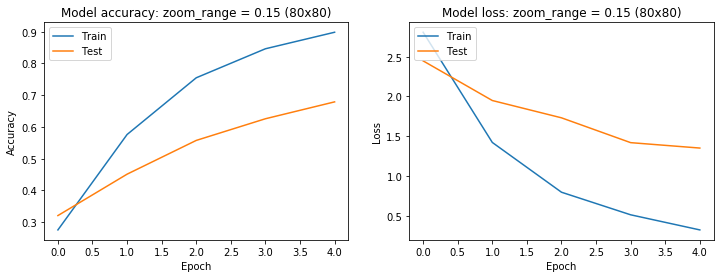


Configuration: zoom_range = 0.2 (80x80). Validation accuracy: 0.6720160245895386


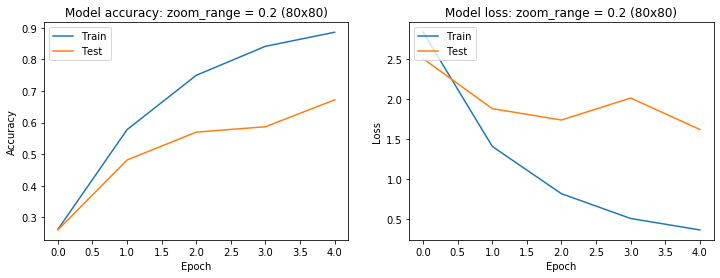


Configuration: zoom_range = 0.25 (80x80). Validation accuracy: 0.7101303935050964


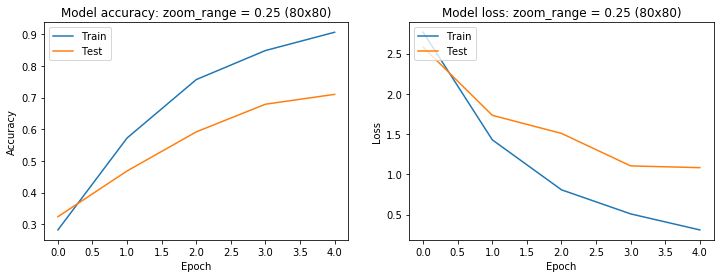


Configuration: shear_range = 0.0 (100x100). Validation accuracy: 0.6479438543319702


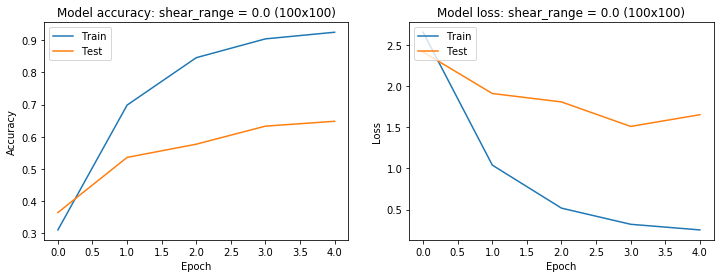


Configuration: shear_range = 0.05 (100x100). Validation accuracy: 0.6900702118873596


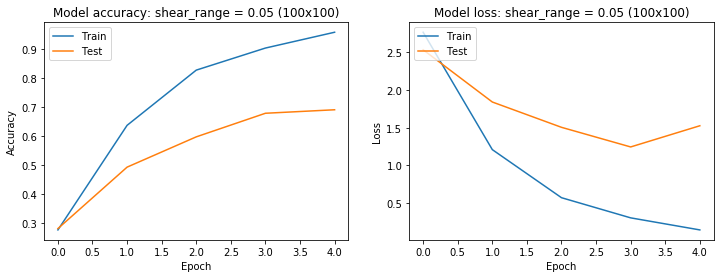


Configuration: shear_range = 0.1 (100x100). Validation accuracy: 0.6579739451408386


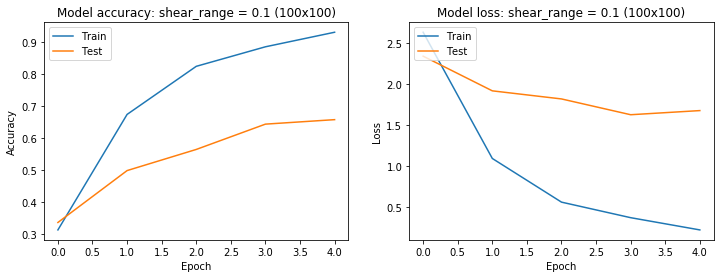


Configuration: shear_range = 0.15 (100x100). Validation accuracy: 0.6278836727142334


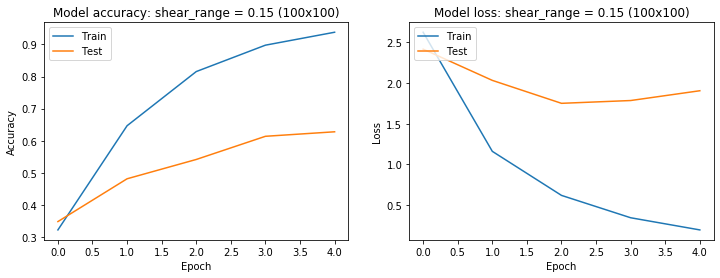


Configuration: shear_range = 0.2 (100x100). Validation accuracy: 0.6449348330497742


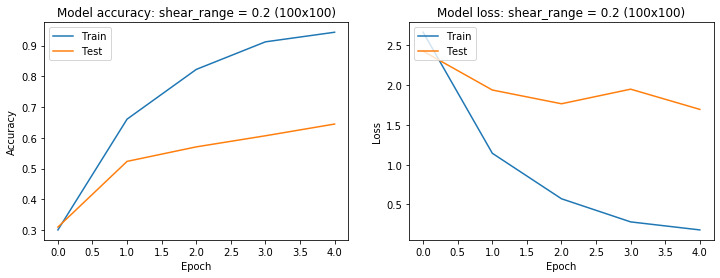


Configuration: shear_range = 0.25 (100x100). Validation accuracy: 0.6700100302696228


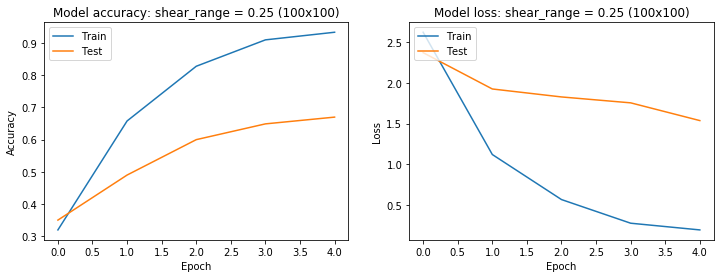


Configuration: zoom_range = 0.0 (100x100). Validation accuracy: 0.6940822601318359


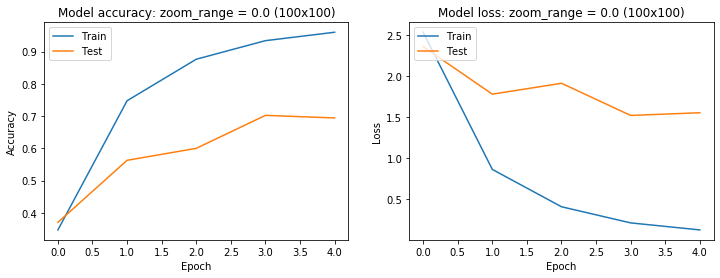


Configuration: zoom_range = 0.05 (100x100). Validation accuracy: 0.5817452073097229


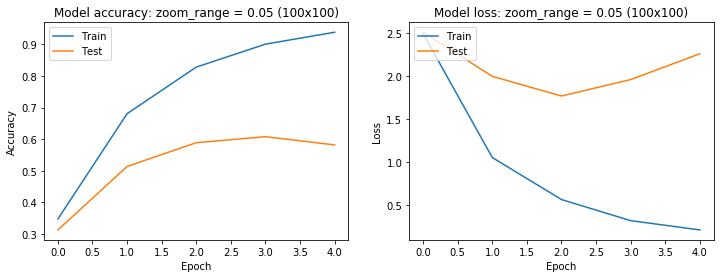


Configuration: zoom_range = 0.1 (100x100). Validation accuracy: 0.7031093239784241


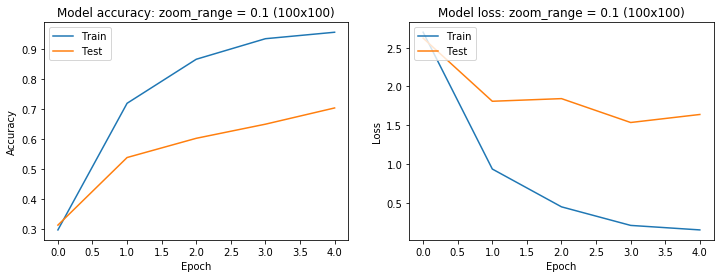


Configuration: zoom_range = 0.15 (100x100). Validation accuracy: 0.6790370941162109


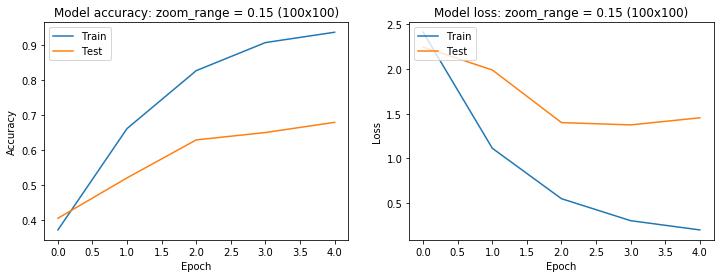


Configuration: zoom_range = 0.2 (100x100). Validation accuracy: 0.6880642175674438


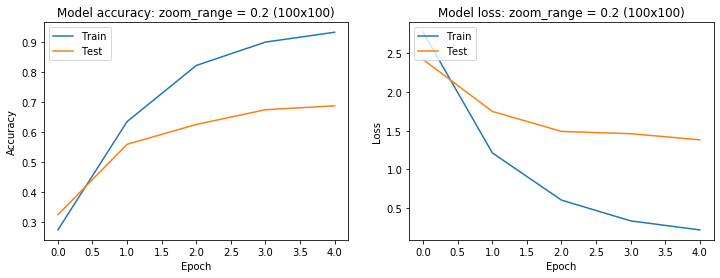


Configuration: zoom_range = 0.25 (100x100). Validation accuracy: 0.6980943083763123


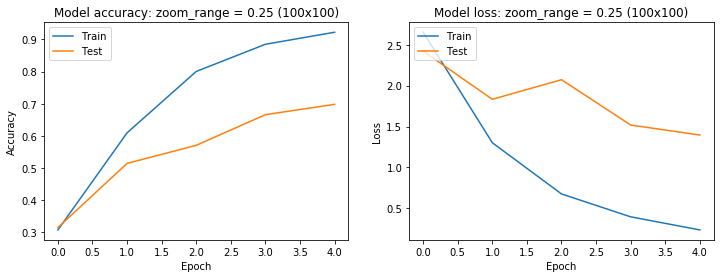

In [29]:
for (imgw,imgh), k, v, h in res:
     plot(h, title='{} = {} ({}x{})'.format(k,v, imgw,imgh))